# Imports

In [ ]:
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Import dataset and cleaning


In [ ]:
df = pd.read_csv("spam_dataset.csv", encoding="latin")
df.head()


In [ ]:
# Clean column names
df = df.rename(columns={'label_num':'label_encoded'})
df = df[['label_encoded','text']]

df.head()

In [ ]:
# Get the length of the text, will be used for comparison later
li = []
for i in df['text']:
    li.append(len(nltk.word_tokenize(i)))

df['number_words'] = li
df.sample(3)

# Data Preprocessing

In [ ]:
# Stemming algorithm
ps = PorterStemmer()

# Transforms text by performing the following steps: lowercase, tokenizing, removing non-alphanumeric characters, removing stopwords and punctuation, and stemming
stopwords_set = set(stopwords.words('english'))
# 15sec runtime
def transforming_text(text):
    # Convert to lowercase and tokenize
    tokens = nltk.word_tokenize(text.lower())

    # Remove non-alphanumeric characters, stopwords, and punctuation
    tokens = [ps.stem(token) for token in tokens if token.isalnum() and token not in stopwords_set and token not in string.punctuation]

    return " ".join(tokens)


In [30]:
# Apply the transformation to all text, save in a new column
# This line takes approx 15 seconds to run depending on your pc
df['tranformed text'] = df['text'].apply(transforming_text)

In [31]:
# Vectorize text
cv = CountVectorizer()
tfid = TfidfVectorizer(max_features=3000)

X = tfid.fit_transform(df['tranformed text']).toarray()
y=df['label_encoded'].values


# Run Models


## Train Models

In [32]:
# Init
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

# Default Logistic Regression and XGBoost models:

# Logistic Regression
lr_basic = LogisticRegression(C=1, solver='liblinear', penalty='l2', max_iter=50)
lr_basic.fit(X_train, y_train)

# XGBoost
xgb_basic = XGBClassifier()
xgb_basic.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Tuning Logistic Regression

In [33]:
import matplotlib.pyplot as plt

# Define the grid of hyperparameters for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'penalty': ['l1', 'l2', 'none']  # Penalty term
}

# Exclude non-valid combinations
if 'liblinear' in lr_param_grid['solver'] and 'none' in lr_param_grid['penalty']:
    lr_param_grid['penalty'].remove('none')

for solver in ['lbfgs', 'newton-cg']:
    if 'l1' in lr_param_grid['penalty']:
        lr_param_grid['penalty'].remove('l1')

# Perform Grid Search for Logistic Regression
lr_grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=10),
                              param_grid=lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=20)
lr_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for Logistic Regression
best_params_lr = lr_grid_search.best_params_

# Train Logistic Regression with the best hyperparameters
lr_best = LogisticRegression(**best_params_lr)
lr_best.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", best_params_lr)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


### Plot Linear Regression Hyperparameters

In [34]:
# import numpy as np

# def compare_parameter(param_to_compare, values_to_compare, lr_grid_search, X_train, y_train, X_test, y_test):
#     try:
#         # Extract results from grid search
#         results = lr_grid_search.cv_results_
#         mean_test_scores = results['mean_test_score']

#         # Find the index of the best mean test score
#         best_index = np.argmax(mean_test_scores)

#         # Get the best mean test score and corresponding hyperparameters
#         best_mean_test_score = mean_test_scores[best_index]
#         best_hyperparameters = results['params'][best_index]

#         # Store test scores for comparison
#         test_scores_to_compare = []

#         # Keep other hyperparameters fixed to the best parameters
#         fixed_hyperparameters = best_hyperparameters.copy()

#         for value in values_to_compare:
#             # Update the hyperparameter value to compare

#             if ('liblinear' in lr_param_grid['solver'] and value == 'none') or \
#                 (value == 'l1' and solver in ['lbfgs', 'newton-cg']):
#                     continue
            
#             fixed_hyperparameters[param_to_compare] = value

#             # Train the model with fixed hyperparameters
#             lr_fixed = LogisticRegression(**fixed_hyperparameters)
#             lr_fixed.fit(X_train, y_train)

#             # Evaluate the model and store the test score
#             test_score = lr_fixed.score(X_test, y_test)  # Example metric: accuracy
#             test_scores_to_compare.append(test_score)

#         # Find the maximum test score and corresponding parameter value
#         max_test_score = max(test_scores_to_compare)
#         max_param_value = values_to_compare[np.argmax(test_scores_to_compare)]
        
#         # Print the maximum test score to the console
#         print(f"Maximum test score for {param_to_compare}: {max_test_score} (achieved with {param_to_compare} = {max_param_value})")

#         # Plot comparison
#         plt.figure(figsize=(10, 6))
#         plt.plot(values_to_compare, test_scores_to_compare, marker='o', linestyle='-', color='b')
#         plt.axhline(y=best_mean_test_score, color='r', linestyle='--', label='Best Score with Optimal Parameters')
#         plt.xlabel(param_to_compare)
#         plt.ylabel('Test Score')
#         plt.title('Comparison of {} against Best Parameter'.format(param_to_compare))
#         plt.legend()
#         plt.grid(True)
#         plt.show()

#     except Exception as e:
#         print(f"An error occurred: {str(e)}")

# # Define hyperparameters and values for comparison
# param_types = ['C', 'solver', 'penalty']
# values_to_compare = {
#     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
#     'penalty': ['l1', 'l2', 'none']
# }

# # Perform comparison for each parameter type
# for param_type in param_types:
#     compare_parameter(param_type, values_to_compare[param_type], lr_grid_search, X_train, y_train, X_test, y_test)


In [35]:
# import numpy as np

# def compare_parameter(param_to_compare, values_to_compare, lr_grid_search, X_train, y_train, X_test, y_test):
#     print("Best parameters for Logistic Regression:", best_params_lr)
#     # Extract results from grid search
#     results = lr_grid_search.cv_results_
#     mean_test_scores = results['mean_test_score']

#     # Find the index of the best mean test score
#     best_index = np.argmax(mean_test_scores)

#     # Get the best mean test score and corresponding hyperparameters
#     best_mean_test_score = mean_test_scores[best_index]
#     best_hyperparameters = results['params'][best_index]

#     # Store test scores for comparison
#     test_scores_to_compare = []

#     # Keep other hyperparameters fixed to the best parameters
#     fixed_hyperparameters = best_hyperparameters.copy()

#     zz_good_values_to_compare = []
#     for value in values_to_compare:
#         # Update the hyperparameter value to compare

#         if ('liblinear' in lr_param_grid['solver'] and value == 'none'): 
#         # or \
#         #     (value == 'l1' and solver in ['lbfgs', 'newton-cg']):
#                 continue
        
#         fixed_hyperparameters[param_to_compare] = value

#         # Train the model with fixed hyperparameters
#         lr_fixed = LogisticRegression(**fixed_hyperparameters)
#         lr_fixed.fit(X_train, y_train)

#         # Evaluate the model and store the test score
#         test_score = lr_fixed.score(X_test, y_test)  # Example metric: accuracy
#         test_scores_to_compare.append(test_score)
#         zz_good_values_to_compare.append(value)

#     # Find the maximum test score and corresponding parameter value
#     max_test_score = max(test_scores_to_compare)
#     max_param_value = values_to_compare[np.argmax(test_scores_to_compare)]
    
#     # Print the maximum test score to the console
#     print(f"Maximum test score for {param_to_compare}: {max_test_score} (achieved with {param_to_compare} = {max_param_value})")

#     # Plot comparison
#     plt.figure(figsize=(10, 6))
#     plt.plot(zz_good_values_to_compare, test_scores_to_compare, marker='o', linestyle='-', color='b')
#     plt.axhline(y=best_mean_test_score, color='r', linestyle='--', label='Best Score with Optimal Parameters')
#     plt.xlabel(param_to_compare)
#     plt.ylabel('Test Score')
#     plt.title('Comparison of {} against Best Parameter'.format(param_to_compare))
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Define hyperparameters and values for comparison
# param_types = ['C', 'solver', 'penalty']
# # values_to_compare = {
# #     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
# #     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
# #     'penalty': ['l1', 'l2', 'none']
# # }

# # Perform comparison for each parameter type
# for param_type in param_types:
#     compare_parameter(param_type, lr_param_grid[param_type], lr_grid_search, X_train, y_train, X_test, y_test)


In [36]:
# import numpy as np

# def compare_parameter(param_to_compare, values_to_compare, lr_grid_search, X_train, y_train, X_test, y_test):
#     # print("Best parameters for Logistic Regression:", best_params_lr)
#     # Extract results from grid search
#     results = lr_grid_search.cv_results_
#     # mean_test_scores = results['mean_test_score']

#     # Find the index of the best mean test score
#     # best_index = np.argmax(mean_test_scores)

#     # Get the best mean test score and corresponding hyperparameters
#     # best_mean_test_score = mean_test_scores[best_index]
#     best_score = lr_grid_search.best_score_


#     # best_hyperparameters = best_params_lr

#     # Store test scores for comparison
#     test_scores_to_compare = []

#     # Keep other hyperparameters fixed to the best parameters
#     fixed_hyperparameters = best_params_lr.copy()

#     zz_good_values_to_compare = []
#     for value in values_to_compare:
#         # Update the hyperparameter value to compare

#         if ('liblinear' in lr_param_grid['solver'] and value == 'none'): 
#         # or \
#         #     (value == 'l1' and solver in ['lbfgs', 'newton-cg']):
#                 continue
        
#         fixed_hyperparameters[param_to_compare] = value

#         # Train the model with fixed hyperparameters
#         lr_fixed = LogisticRegression(**fixed_hyperparameters)
#         lr_fixed.fit(X_train, y_train)

#         # Evaluate the model and store the test score
#         test_score = lr_fixed.score(X_test, y_test)  # Example metric: accuracy
#         test_scores_to_compare.append(test_score)
#         zz_good_values_to_compare.append(value)

#     # Find the maximum test score and corresponding parameter value
#     max_test_score = max(test_scores_to_compare)
#     max_param_value = values_to_compare[np.argmax(test_scores_to_compare)]
    
#     # Print the maximum test score to the console
#     print(f"Maximum test score for {param_to_compare}: {max_test_score} (achieved with {param_to_compare} = {max_param_value})")
#     print("Best parameters for Logistic Regression:", best_params_lr)

#     # Plot comparison
#     plt.figure(figsize=(10, 6))
#     plt.plot(zz_good_values_to_compare, test_scores_to_compare, marker='o', linestyle='-', color='b')
#     plt.axhline(y=best_score, color='r', linestyle='--', label='Best Score with Optimal Parameters')
#     plt.xlabel(param_to_compare)
#     plt.ylabel('Test Score')
#     plt.title('Comparison of {} against Best Parameter'.format(param_to_compare))
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Define hyperparameters and values for comparison
# param_types = ['C', 'solver', 'penalty']
# # values_to_compare = {
# #     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
# #     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
# #     'penalty': ['l1', 'l2', 'none']
# # }

# # Perform comparison for each parameter type
# for param_type in param_types:
#     compare_parameter(param_type, lr_param_grid[param_type], lr_grid_search, X_train, y_train, X_test, y_test)


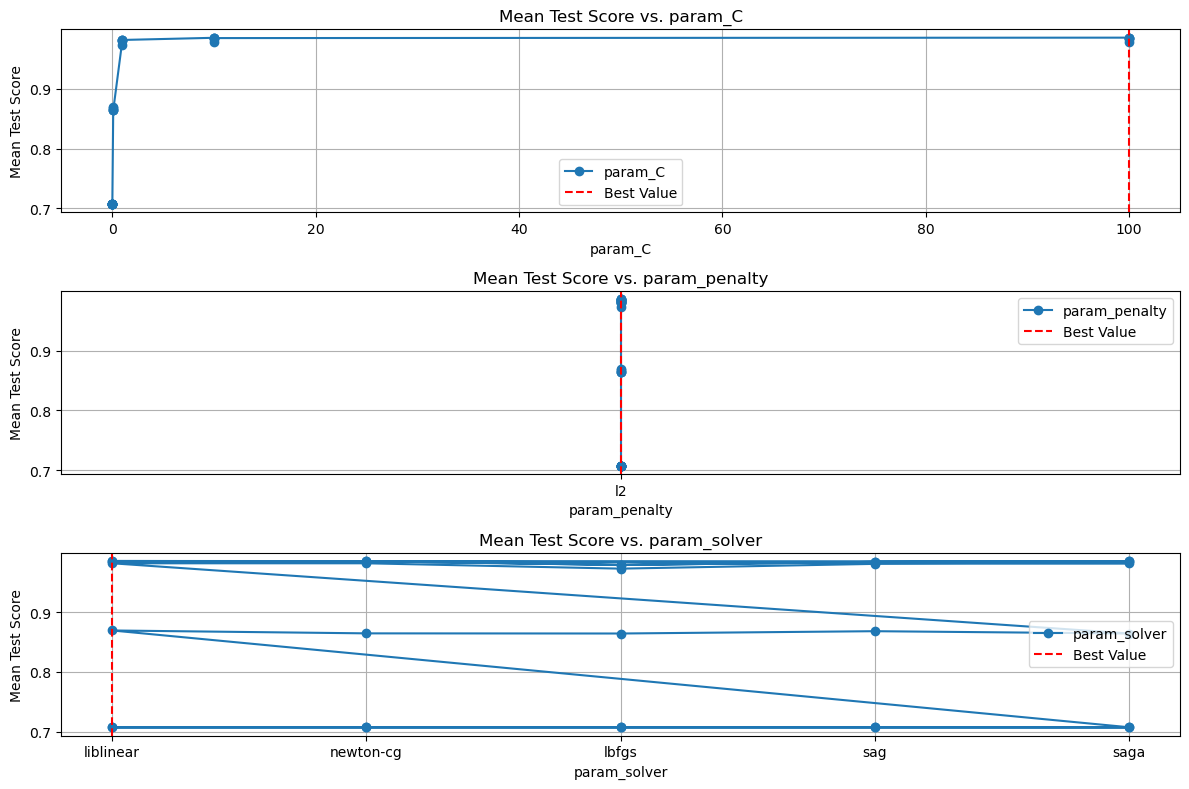

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert cv_results_ to DataFrame
cv_results_df = pd.DataFrame(lr_grid_search.cv_results_)

# Extract relevant columns
param_columns = [col for col in cv_results_df.columns if col.startswith("param_")]
mean_test_score = cv_results_df["mean_test_score"]

# Plot the data for each hyperparameter separately
plt.figure(figsize=(12, 8))
for i, param_col in enumerate(param_columns):
    plt.subplot(len(param_columns), 1, i+1)
    plt.plot(cv_results_df[param_col], mean_test_score, marker='o', linestyle='-', label=param_col)
    
    # Highlight the best value
    best_index = cv_results_df["mean_test_score"].idxmax()
    best_value = cv_results_df[param_col][best_index]
    plt.axvline(x=best_value, color='r', linestyle='--', label='Best Value')

    plt.xlabel(param_col)
    plt.ylabel("Mean Test Score")
    plt.title("Mean Test Score vs. " + param_col)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [38]:
# import matplotlib.pyplot as plt

# # Define hyperparameters and their ranges
# hyperparameters = ['C', 'solver', 'penalty']
# hyperparameter_ranges = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
#     'penalty': ['l1', 'l2', 'none']
# }

# # Perform sensitivity analysis
# plt.figure(figsize=(18, 12))
# subplot_index = 1
# for param1 in hyperparameters:
#     for param2 in hyperparameters:
#         if param1 != param2:
#             plt.subplot(3, 3, subplot_index)
#             subplot_index += 1
#             for value1 in hyperparameter_ranges[param1]:
#                 for value2 in hyperparameter_ranges[param2]:
#                     # Filter results for the current hyperparameter combination
#                     scores = [mean_cv_score for params, mean_cv_score in zip(lr_grid_search.cv_results_['params'], lr_grid_search.cv_results_['mean_test_score']) if params[param1] == value1 and params[param2] == value2]
#                     # Plot the scores
#                     plt.plot(scores, label=f'{param1}={value1}, {param2}={value2}')
#             plt.title(f'Sensitivity Analysis: {param1} vs {param2}')
#             plt.xlabel('Iteration')
#             plt.ylabel('Mean CV Score')
#             plt.legend()

# plt.tight_layout()
# plt.show()



# # import matplotlib.pyplot as plt

# # # Extract grid search results
# # results = lr_grid_search.cv_results_

# # # Define hyperparameters
# # hyperparameters = ['C', 'solver', 'penalty']

# # # Plot the impact of each hyperparameter on performance
# # plt.figure(figsize=(15, 12))
# # for i, hyperparam in enumerate(hyperparameters):
# #     plt.subplot(3, 1, i+1)
# #     for value in lr_param_grid[hyperparam]:
# #         # Filter results for the current hyperparameter value
# #         scores = [mean_cv_score for params, mean_cv_score in zip(results['params'], results['mean_test_score']) if params[hyperparam] == value]
# #         # Plot the scores
# #         plt.plot(scores, label=f'{hyperparam}={value}')
# #     plt.title(f'Impact of {hyperparam} on Performance')
# #     plt.xlabel('Iteration')
# #     plt.ylabel('Mean CV Score')
# #     plt.legend()
# # plt.tight_layout()
# # plt.show()


In [39]:
# # Plot LR

# # Get the results of the grid search
# import numpy as np


# results = lr_grid_search.cv_results_
# params = results['params']
# mean_test_scores = results['mean_test_score']

# # Extract hyperparameter values for plotting
# C_values = [param['C'] for param in params]
# solver_values = [param['solver'] for param in params]
# penalty_values = [param['penalty'] for param in params]


# # Create 3D plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot hyperparameter values vs mean test scores
# sc = ax.scatter(C_values, solver_values, mean_test_scores, c=mean_test_scores, cmap='viridis')
# ax.set_xlabel('C')
# ax.set_ylabel('Solver')
# ax.set_zlabel('Mean Test Score')
# ax.set_title('Grid Search Results for Logistic Regression')

# # Highlight the best combination
# best_index = np.argmax(mean_test_scores)
# ax.scatter(C_values[best_index], solver_values[best_index], mean_test_scores[best_index], color='red', marker='*', s=200, label='Best Combination')

# # Add color bar
# cbar = fig.colorbar(sc)
# cbar.set_label('Mean Test Score')

# # Rotate the plot for better visualization
# ax.view_init(elev=20, azim=30)

# # Show plot
# plt.legend()
# plt.show()

### Tuning XG Boost

In [40]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# Define a smaller grid of hyperparameters for XGBoost
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define a smaller grid of hyperparameters for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2],
    'n_estimators': [100, 200]
}

# Create XGBoost classifier
xgb = XGBClassifier()

# Perform Randomized Search for XGBoost
xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, verbose=10, random_state=42)
xgb_random_search.fit(X_train, y_train)

# Get the best hyperparameters for XGBoost
best_params_xgb = xgb_random_search.best_params_

# Train XGBoost with the best hyperparameters
xgb_best = XGBClassifier(**best_params_xgb)
xgb_best.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
# import matplotlib.pyplot as plt

# # Define hyperparameters (excluding 'n_estimators') and their values
# hyperparameters = ['learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']
# n_estimators_values = xgb_param_grid['n_estimators']  # Extract 'n_estimators' values

# # Extract grid search results
# results = xgb_grid_search.cv_results_

# # Plot the impact of each hyperparameter on performance (excluding 'n_estimators')
# plt.figure(figsize=(12, 8))
# for hyperparam in hyperparameters:
#     # Extract the hyperparameter values and their corresponding mean test scores
#     values = results['param_' + hyperparam]
#     scores = results['mean_test_score']
#     # Plot the scores against the hyperparameter values
#     plt.plot(values, scores, marker='o', label=hyperparam)
# plt.xlabel('Hyperparameter Value')
# plt.ylabel('Mean Test Score')
# plt.title('Impact of Hyperparameters on Model Performance (excluding n_estimators)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the impact of 'n_estimators' on performance
# plt.figure(figsize=(8, 6))
# values = n_estimators_values
# scores = results['mean_test_score']
# plt.plot(values, scores, marker='o')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Test Score')
# plt.title('Impact of n_estimators on Model Performance')
# plt.grid(True)
# plt.show()


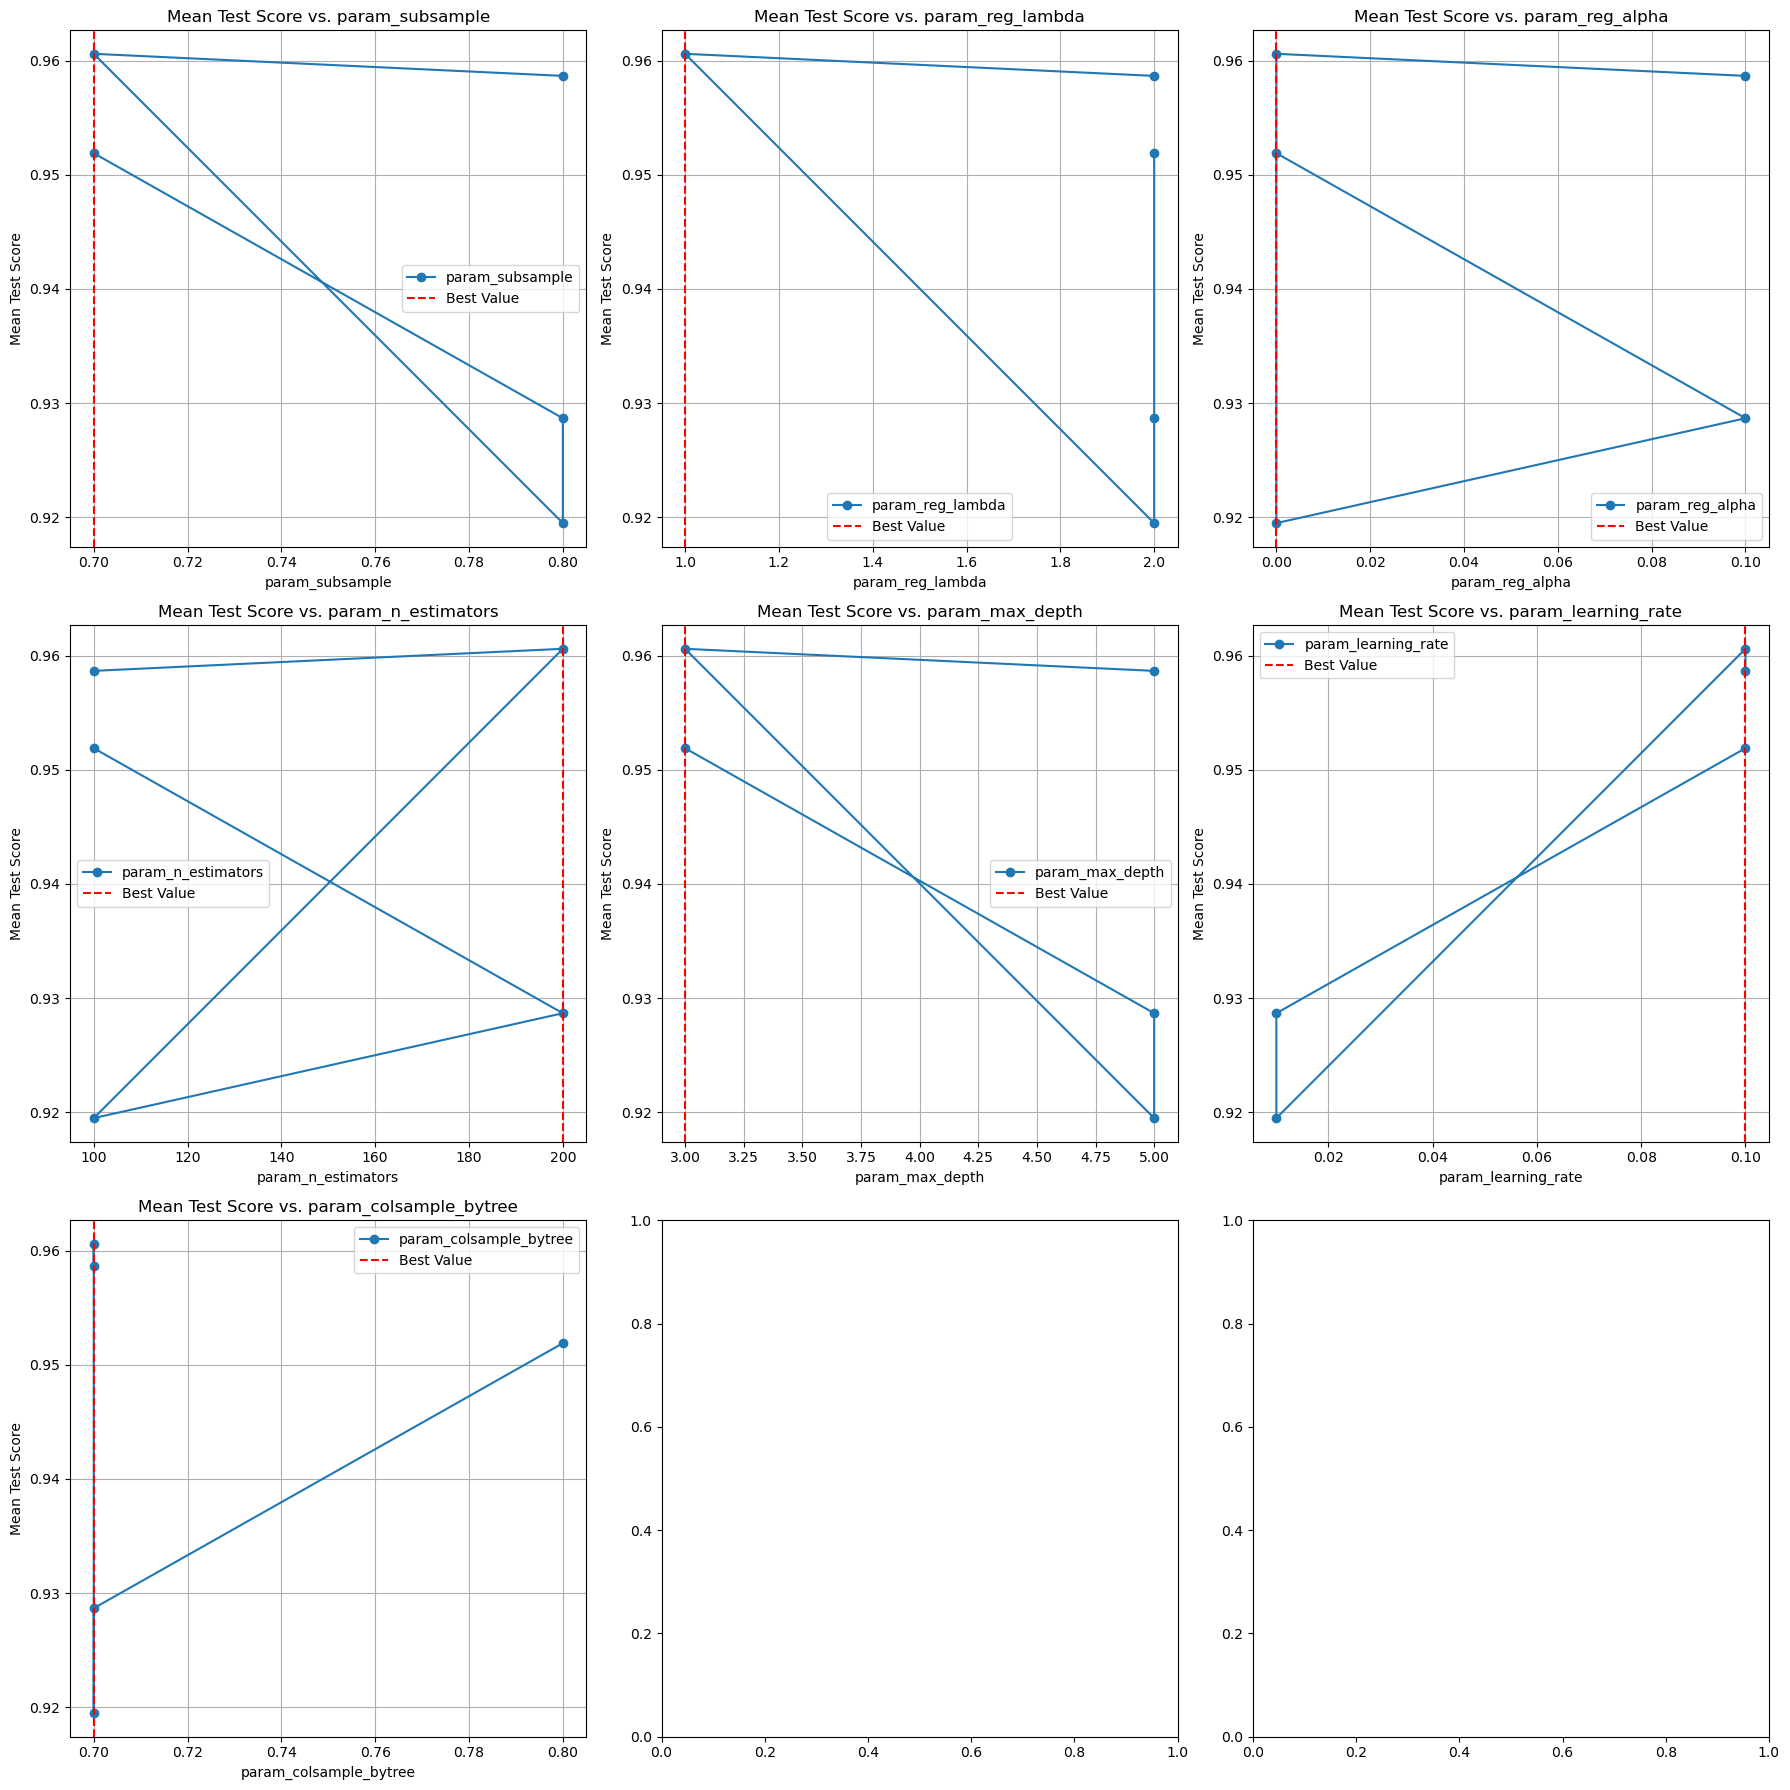

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert cv_results_ to DataFrame
cv_results_df = pd.DataFrame(xgb_random_search.cv_results_)

# Extract relevant columns
param_columns = [col for col in cv_results_df.columns if col.startswith("param_")]
mean_test_score = cv_results_df["mean_test_score"]

# Plot the data for each hyperparameter separately
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, param_col in enumerate(param_columns):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    ax.plot(cv_results_df[param_col], mean_test_score, marker='o', linestyle='-', label=param_col)
    
    # Highlight the best value
    best_index = cv_results_df["mean_test_score"].idxmax()
    best_value = cv_results_df[param_col][best_index]
    ax.axvline(x=best_value, color='r', linestyle='--', label='Best Value')

    ax.set_xlabel(param_col)
    ax.set_ylabel("Mean Test Score")
    ax.set_title("Mean Test Score vs. " + param_col)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [43]:
# # Plot the impact of each hyperparameter on performance
# hyperparameters = ['learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda', 'n_estimators']

# plt.figure(figsize=(15, 12))
# for i, hyperparam in enumerate(hyperparameters):
#     plt.subplot(3, 3, i+1)
#     for value in xgb_param_grid[hyperparam]:
#         # Filter results for the current hyperparameter value
#         scores = [mean_cv_score for params, mean_cv_score in zip(xgb_random_search.cv_results_['params'], xgb_random_search.cv_results_['mean_test_score']) if params[hyperparam] == value]
#         # Plot the scores
#         plt.plot(scores, label=f'{hyperparam}={value}')
    
#     # Plot the best result
#     best_score = xgb_random_search.best_score_
#     best_hyperparam_value = xgb_random_search.best_params_[hyperparam]
#     plt.axhline(y=best_score, color='r', linestyle='--', label=f'Best Score: {best_score:.2f} ({hyperparam}={best_hyperparam_value})')
    
#     plt.title(f'Impact of {hyperparam} on Performance')
#     plt.xlabel('Iterations')
#     plt.ylabel('Mean CV Score')
#     plt.legend()
# plt.tight_layout()
# plt.show()

In [44]:
# import matplotlib.pyplot as plt

# # Get feature importances from the XGBoost model
# feature_importances = xgb_best.feature_importances_

# # Define hyperparameters
# hyperparameters = ['learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda', 'n_estimators']

# # Ensure that feature_importances has the same length as hyperparameters
# feature_importances = feature_importances[:len(hyperparameters)]

# # Create a bar plot for feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(hyperparameters, feature_importances)
# plt.xlabel('Feature Importance')
# plt.ylabel('Hyperparameter')
# plt.title('Significance of Hyperparameters (Feature Importances)')
# plt.grid(axis='x')
# plt.show()

# for hyperparam, importance in zip(hyperparameters, feature_importances):
#     print(f"{hyperparam}: {importance}")

## Test
Modify the custom_email or use one of the default emails to check if it is spam.

In [45]:
# Test the models on the standard test set

# Predictions on test set
lr_pred = lr_best.predict(X_test)
xgb_pred = xgb_best.predict(X_test)

# Calculate accuracy for Logistic Regression
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Calculate accuracy for XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Default values:

lr_basic_pred = lr_basic.predict(X_test)
lr_basic_accuracy = accuracy_score(y_test, lr_basic_pred)
print(f"Logistic Regression Basic Accuracy: {lr_basic_accuracy:.4f}")


xgb_basic_pred = xgb_basic.predict(X_test)
xgb_basic_accuracy = accuracy_score(y_test, xgb_basic_pred)
print(f"XGBoost Basic Accuracy: {xgb_basic_accuracy:.4f}")



Logistic Regression Accuracy: 0.9826
XGBoost Accuracy: 0.9700
Logistic Regression Basic Accuracy: 0.9845
XGBoost Basic Accuracy: 0.9758


In [46]:
# # Test the models on a custom test set (temporarily commented out)
# custom_spam_email = "Congratulations! You've won a prize. Claim it now."
# custom_real_email = "Hi John, I hope you're doing well. I wanted to follow up on our meeting last week and discuss the next steps for the project. Please let me know when you're available for a call. Looking forward to hearing from you. Best regards, Anthony"

# custom_email = custom_spam_email
# # custom_email = custom_real_email
# # custom_email = "" 

# preprocessed_text = transforming_text(custom_email)

# # Transform the preprocessed text using the same TfidfVectorizer
# custom_text_vectorized = tfid.transform([preprocessed_text]).toarray()

# # Binary spam prediction
# prediction = lr.predict(custom_text_vectorized)

# # Predict the probability of the text being spam
# probability_scores = lr.predict_proba(custom_text_vectorized)
# spam_probability = probability_scores[0, 1]

# print(f"Spam Probability: {spam_probability:.2%}")

# # Internally does [0-50) real [50-100] spam
# if prediction == 1:
#     print("This is a spam message!")
# else:
#     print("This is a real message.")


# Comparison

In [47]:
# TBD, need multiple models to compare